# Section 6.2.1 Biases in Record Matching Scores

In [2]:
import os
import numpy as np
import pandas as pd
from utils import *
from sklearn.metrics import roc_curve, auc
import pickle
import matplotlib.pyplot as plt

# Load sensitive attribute dictionary for the test set
with open('Results/SavedParams/sens_attr_dict_test.pkl', 'rb') as file:
    sens_attr_dict_test = pickle.load(file)

# Set the base directory path
path_base = os.getcwd()

# Define the tasks (datasets) and models for evaluation
tasks = ['Fodors-Zagat', 'DBLP-GoogleScholar', 'iTunes-Amazon', 'Walmart-Amazon', 'Amazon-Google', 'Beer', 'DBLP-ACM']
models = ['deepmatcher', 'DITTO', 'EMTransformer', 'HierGAT', 'HierMatcher']

# Loop over each model and task for analysis
for model in models:
    for task in tasks:
        
        # Load test data and prediction scores
        df_test = pd.read_csv(path_base + '/Input/Dataset/' + task + '/test.csv')
        scores_test = pd.read_csv(path_base + '/Input/Scores/' + task + '_' + model + '/score_test.csv')
        sens_test = sens_attr_dict_test[task]

        # Identify the prediction column (either probability or binary)
        for x in list(scores_test.columns):
            if len(np.unique(scores_test[x])) > 2:
                prob_test = scores_test[x]  # Probability scores
            else:
                y_test = scores_test[x]     # Binary labels

        # Assign arrays for sensitive attributes, probabilities, and true labels
        sens_array = sens_test
        prob_array = prob_test
        y_array = y_test

        # Separate probabilities based on sensitive attribute (1 for minority, 0 for majority)
        prob_minor = prob_array[sens_array == 1]
        prob_major = prob_array[sens_array == 0]

        # Separate true labels based on sensitive attribute
        y_minor = y_array[sens_array == 1]
        y_major = y_array[sens_array == 0]

        # Initialize lists to store fairness metrics for Disparate Impact (DP), Equal Opportunity (EO), and Equalized Odds (EOD)
        DP, EO, EOD = [], [], []
        PR_minor_all, TPR_minor_all = [], []  # Precision and True Positive Rate for minority group
        PR_major_all, TPR_major_all = [], []  # Precision and True Positive Rate for majority group

        # Compute ROC curve and AUC for all groups combined
        fpr, tpr, _ = roc_curve(y_array, prob_array)
        auc_all = 100 * auc(fpr, tpr)

        # Compute ROC curve and AUC specifically for the majority group
        fpr, tpr, _ = roc_curve(y_major, prob_major)
        auc_major = 100 * auc(fpr, tpr)

        # Define the number of threshold points for analysis
        N = 500
        for theta in np.linspace(0, 1, N):
            
            # Calculate metrics for minority group
            y_pred = np.array([1 if score > theta else 0 for score in prob_minor])
            tn, fp, fn, tp = confusion_matrix(y_minor, y_pred).ravel()
            tpr = tp / (tp + fn)
            pr = (tp + fp) / len(y_minor)
            fpr = fp / (fp + tn)
            PR_minor, FPR_minor, TPR_minor = pr, fpr, tpr
            PR_minor_all.append(PR_minor)
            TPR_minor_all.append(TPR_minor)

            # Calculate metrics for majority group
            y_pred = np.array([1 if score > theta else 0 for score in prob_major])
            tn, fp, fn, tp = confusion_matrix(y_major, y_pred).ravel()
            tpr = tp / (tp + fn)
            pr = (tp + fp) / len(y_major)
            fpr = fp / (fp + tn)
            PR_major, FPR_major, TPR_major = pr, fpr, tpr
            PR_major_all.append(PR_major)
            TPR_major_all.append(TPR_major)

            # Calculate fairness metrics for current threshold
            EOD.append((np.abs(TPR_major - TPR_minor) + np.abs(FPR_major - FPR_minor)))  # Equalized Odds
            EO.append(np.abs(TPR_major - TPR_minor))  # Equal Opportunity
            DP.append(np.abs(PR_major - PR_minor))  # Disparate Impact

        # Compute average disparities for fairness metrics
        DSP_EOD = 100 * np.average(EOD)
        DSP_EO = 100 * np.average(EO)
        DSP_DP = 100 * np.average(DP)
        Frac = np.linspace(0, 1, N)

        # Print model and task-level fairness results
        print(task, model, '\n\t', r'DP_s: ' + str(round(DSP_DP, 2)), '| EO_s: ' + str(round(DSP_EO, 2)), '| EOD_s: ' + str(round(DSP_EOD, 2)), '| AUC:' + str(round(auc_all, 2)))

        # Display specific thresholds and corresponding fairness metrics
        for i in [50, 250, 500 * 8 // 10, 500 * 95 // 100]:
            print('\t', 'threshold:', round(Frac[i], 2), '(DP, EO, EOD) --> ', round(100 * (DP[i]), 2), '|', round(100 * EO[i], 2), '|', round(100 * EOD[i], 2))
        print()


Fodors-Zagat deepmatcher 
	 DP_s: 2.86 | EO_s: 5.51 | EOD_s: 5.77 | AUC:100.0
	 threshold: 0.1 (DP, EO, EOD) -->  5.01 | 0.0 | 2.19
	 threshold: 0.5 (DP, EO, EOD) -->  2.45 | 5.26 | 5.26
	 threshold: 0.8 (DP, EO, EOD) -->  2.45 | 5.26 | 5.26
	 threshold: 0.95 (DP, EO, EOD) -->  1.92 | 15.79 | 15.79

DBLP-GoogleScholar deepmatcher 
	 DP_s: 6.15 | EO_s: 11.53 | EOD_s: 11.76 | AUC:98.41
	 threshold: 0.1 (DP, EO, EOD) -->  6.58 | 7.58 | 7.79
	 threshold: 0.5 (DP, EO, EOD) -->  6.61 | 10.76 | 10.96
	 threshold: 0.8 (DP, EO, EOD) -->  7.38 | 15.13 | 15.31
	 threshold: 0.95 (DP, EO, EOD) -->  1.8 | 7.87 | 7.96

iTunes-Amazon deepmatcher 
	 DP_s: 13.84 | EO_s: 17.98 | EOD_s: 23.88 | AUC:96.97
	 threshold: 0.1 (DP, EO, EOD) -->  21.12 | 9.09 | 26.16
	 threshold: 0.5 (DP, EO, EOD) -->  16.19 | 21.02 | 28.34
	 threshold: 0.8 (DP, EO, EOD) -->  9.18 | 14.77 | 14.77
	 threshold: 0.95 (DP, EO, EOD) -->  7.02 | 25.0 | 25.0

Walmart-Amazon deepmatcher 
	 DP_s: 3.74 | EO_s: 13.8 | EOD_s: 14.79 | AUC:82

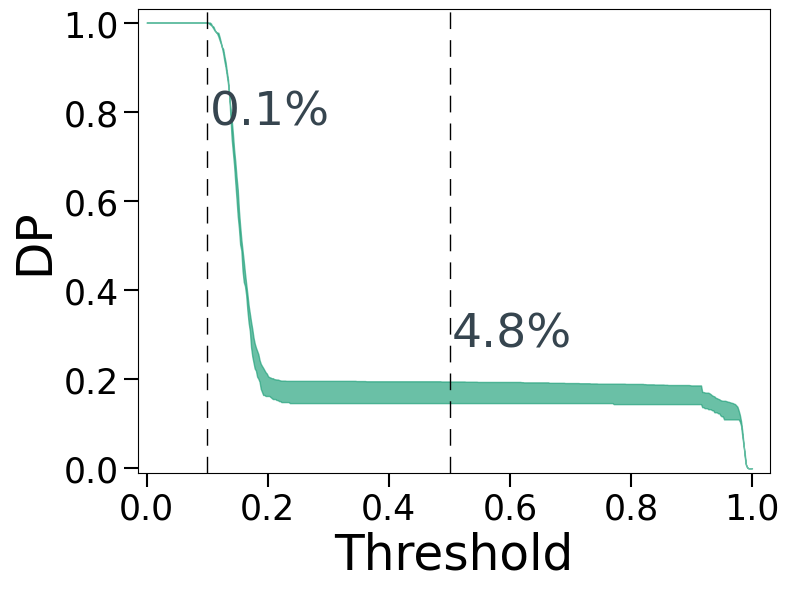

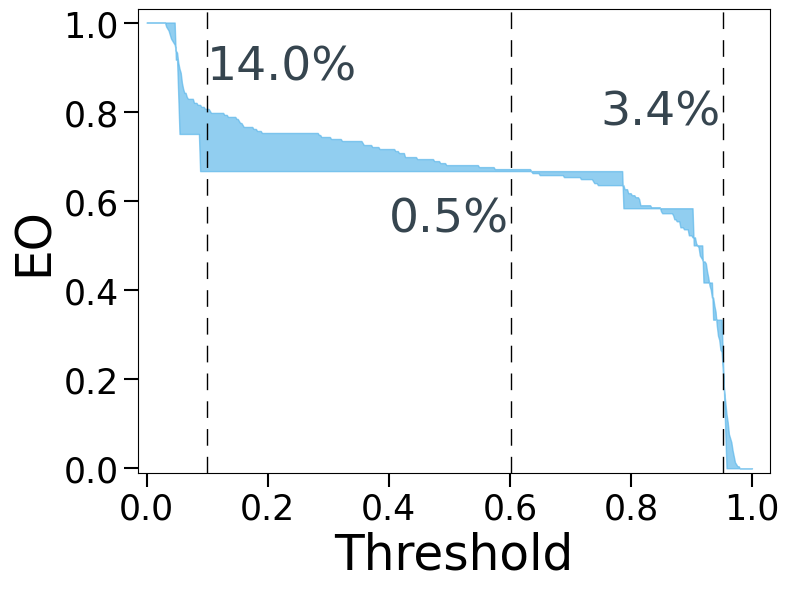

In [4]:
import numpy as np
import pandas as pd
from utils import *
from sklearn.metrics import roc_curve, auc
import pickle



# Load sensitive attribute dictionary for the test set
with open('Results/SavedParams/sens_attr_dict_test.pkl', 'rb') as file:
    sens_attr_dict_test = pickle.load(file)

# Set base path for data access
path_base = os.getcwd()

# Define model and task for analysis
model = 'HierMatcher'
task = 'DBLP-ACM'

# Load test dataset and model prediction scores
df_test = pd.read_csv(path_base + '/Input/Dataset/' + task + '/test.csv')
scores_test = pd.read_csv(path_base + '/Input/Scores/' + task + '_' + model + '/score_test.csv')
sens_test = sens_attr_dict_test[task]

# Identify the prediction column: if continuous, it's a probability score; otherwise, it's binary labels
for x in list(scores_test.columns):
    if len(np.unique(scores_test[x])) > 2:
        prob_test = scores_test[x]  # Assign probability scores
    else:
        y_test = scores_test[x]     # Assign binary labels

# Assign arrays for sensitive attributes, probabilities, and true labels
sens_array = sens_test
prob_array = prob_test
y_array = y_test

# Separate probabilities based on sensitive attribute (1 for minority, 0 for majority)
prob_minor = prob_array[sens_array == 1]
prob_major = prob_array[sens_array == 0]

# Separate true labels based on sensitive attribute
y_minor = y_array[sens_array == 1]
y_major = y_array[sens_array == 0]

# Initialize lists to store fairness metrics for Disparate Impact (DP) and precision rates
DP, EO, EOD = [], [], []
PR_minor_all = []  # Precision for minority group across thresholds
PR_major_all = []  # Precision for majority group across thresholds

# Define the number of threshold points for analysis
N = 500
for theta in np.linspace(0, 1, N):
    
    # Calculate metrics for minority group at the current threshold
    y_pred = np.array([1 if score > theta else 0 for score in prob_minor])
    tn, fp, fn, tp = confusion_matrix(y_minor, y_pred).ravel()
    tpr = tp / (tp + fn)  # True Positive Rate
    pr = (tp + fp) / len(y_minor)  # Precision Rate
    fpr = fp / (fp + tn)  # False Positive Rate
    PR_minor, FPR_minor, TPR_minor = pr, fpr, tpr
    PR_minor_all.append(PR_minor)

    # Calculate metrics for majority group at the current threshold
    y_pred = np.array([1 if score > theta else 0 for score in prob_major])
    tn, fp, fn, tp = confusion_matrix(y_major, y_pred).ravel()
    tpr = tp / (tp + fn)
    pr = (tp + fp) / len(y_major)
    fpr = fp / (fp + tn)
    PR_major, FPR_major, TPR_major = pr, fpr, tpr
    PR_major_all.append(PR_major)

    # Append Disparate Impact (DP) between groups at current threshold
    DP.append(np.abs(PR_major - PR_minor))

# Calculate the average Disparate Impact (DP) over all thresholds
DSP_DP = 100 * np.average(DP)
Frac = np.linspace(0, 1, N)

# Plot settings based on fig_params
plt.figure(figsize=fig_size)

# Plot disparity between precision rates for each group, with shading indicating disparity
plt.xticks(fontsize=F_ax)
plt.yticks(fontsize=F_ax)
plt.fill_between(Frac, PR_minor_all, PR_major_all, color='#1B9E77', alpha=fig_alpha, label=r'$DSP_{DP}$: 3.89%')

# Set axis labels
plt.ylabel('DP', fontsize=F_lbl)
plt.xlabel('Threshold', fontsize=F_lbl)
plt.ylim([-0.01, 1.03])
plt.xlim([-0.015, 1.03])

# Add vertical lines at specified threshold points
for i in [500 * 10 // 100, 500 * 50 // 100]:
    x = Frac[i]
    plt.axvline(x=x, color='black', linestyle='--', linewidth=1, dashes=(12, 8))

# Add text labels for disparity percentage at specific thresholds
x = Frac[500 * 10 // 100]
y = 0.8
plt.text(
    x + 0.10271, y, str(round(100 * DP[500 * 10 // 100] + 0.01, 1)) + r'%',
    rotation=0,
    va='center', ha='center',
    fontsize=34, color='#36454F'
)

x = Frac[500 * 50 // 100]
y = 0.3
plt.text(
    x + 0.10271, y, str(round(100 * DP[500 * 50 // 100], 1)) + '%',
    rotation=0,
    va='center', ha='center',
    fontsize=34, color='#36454F'
)

# Customize tick parameters and save the plot
plt.tick_params(axis='both', which='both', length=tick_l, width=tick_w)
plt.tight_layout()
plt.savefig('Results/Figures/PR_compare.pdf')


import numpy as np
import pandas as pd
from utils import *
from sklearn.metrics import roc_curve, auc
import pickle

# Load sensitive attribute dictionary for the test set
with open('Results/SavedParams/sens_attr_dict_test.pkl', 'rb') as file:
    sens_attr_dict_test = pickle.load(file)

# Set base path and define task and model for analysis
path_base = os.getcwd()
task = 'Amazon-Google'
model = 'Deepmatcher'

# Load test data and model prediction scores
df_test = pd.read_csv(path_base + '/Input/Dataset/' + task + '/test.csv')
scores_test = pd.read_csv(path_base + '/Input/Scores/' + task + '_' + model + '/score_test.csv')
sens_test = sens_attr_dict_test[task]

# Determine whether the prediction column is probability-based or binary
for x in list(scores_test.columns):
    if len(np.unique(scores_test[x])) > 2:
        prob_test = scores_test[x]  # Assign probability scores
    else:
        y_test = scores_test[x]     # Assign binary labels

# Assign arrays for sensitive attributes, probabilities, and true labels
sens_array = sens_test
prob_array = prob_test
y_array = y_test

# Separate probabilities based on sensitive attribute (1 for minority, 0 for majority)
prob_minor = prob_array[sens_array == 1]
prob_major = prob_array[sens_array == 0]

# Separate true labels based on sensitive attribute
y_minor = y_array[sens_array == 1]
y_major = y_array[sens_array == 0]

# Initialize lists to store fairness metrics for Disparate Impact (DP) and Equal Opportunity (EO)
DP, EO, EOD = [], [], []
PR_minor_all, TPR_minor_all = [], []  # Precision and True Positive Rate for minority group
PR_major_all, TPR_major_all = [], []  # Precision and True Positive Rate for majority group

# Define the number of threshold points for analysis
N = 500
for theta in np.linspace(0, 1, N):
    
    # Calculate metrics for minority group at the current threshold
    y_pred = np.array([1 if score > theta else 0 for score in prob_minor])
    tn, fp, fn, tp = confusion_matrix(y_minor, y_pred).ravel()
    tpr = tp / (tp + fn)  # True Positive Rate
    pr = (tp + fp) / len(y_minor)  # Precision Rate
    fpr = fp / (fp + tn)  # False Positive Rate
    PR_minor, FPR_minor, TPR_minor = pr, fpr, tpr
    PR_minor_all.append(PR_minor)
    TPR_minor_all.append(TPR_minor)

    # Calculate metrics for majority group at the current threshold
    y_pred = np.array([1 if score > theta else 0 for score in prob_major])
    tn, fp, fn, tp = confusion_matrix(y_major, y_pred).ravel()
    tpr = tp / (tp + fn)
    pr = (tp + fp) / len(y_major)
    fpr = fp / (fp + tn)
    PR_major, FPR_major, TPR_major = pr, fpr, tpr
    PR_major_all.append(PR_major)
    TPR_major_all.append(TPR_major)

    # Append Equal Opportunity (EO) and Disparate Impact (DP) between groups at current threshold
    EO.append(np.abs(TPR_major - TPR_minor))
    DP.append(np.abs(PR_major - PR_minor))

# Calculate the average Equal Opportunity (EO) disparity across all thresholds
DSP_EO = 100 * np.average(EO)
Frac = np.linspace(0, 1, N)

# Plot settings based on fig_params
plt.figure(figsize=fig_size)
plt.xticks(fontsize=F_ax)
plt.yticks(fontsize=F_ax)

# Plot the True Positive Rate (TPR) disparity between groups with shaded area indicating EO disparity
plt.fill_between(Frac, TPR_minor_all, TPR_major_all, color='#56B4E9', alpha=fig_alpha)
plt.ylabel('EO', fontsize=F_lbl)
plt.xlabel('Threshold', fontsize=F_lbl)
plt.ylim([-0.01, 1.03])
plt.xlim([-0.015, 1.03])

# Add vertical lines at specified threshold points
for i in [500 * 10 // 100, 500 * 60 // 100, 500 * 95 // 100]:
    x = Frac[i]
    plt.axvline(x=x, color='black', linestyle='--', linewidth=1, dashes=(12, 8))

# Add text labels for EO disparity percentage at specific thresholds
x = Frac[500 * 10 // 100]
y = 0.9
plt.text(
    x + 0.12271, y, str(round(100 * EO[500 * 10 // 100] + 0.01, 1)) + '%',
    rotation=0,
    va='center', ha='center',
    fontsize=34, color='#36454F'
)

x = Frac[500 * 60 // 100]
y = 0.56
plt.text(
    x - 0.10271, y, str(round(100 * EO[500 * 60 // 100] + 0.01, 1)) + '%',
    rotation=0,
    va='center', ha='center',
    fontsize=34, color='#36454F'
)

x = Frac[500 * 95 // 100]
y = 0.8
plt.text(
    x - 0.10271, y, str(round(100 * EO[500 * 95 // 100], 1)) + '%',
    rotation=0,
    va='center', ha='center',
    fontsize=34, color='#36454F'
)

# Customize tick parameters and save the plot
plt.tick_params(axis='both', which='both', length=tick_l, width=tick_w)
plt.tight_layout()
plt.savefig('Results/Figures/EO_compare.pdf')

